In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist

## Подготовка данных

### Обучающая выборка

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Размытые данные

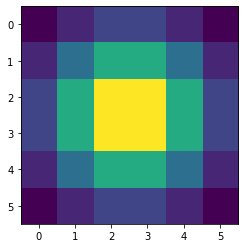

In [3]:
def gkern(kernlen=6, std=1.5):
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d/np.sum(gkern2d)

plt.imshow(gkern(6), interpolation='none')

X_train_blur = [0 for i in range(len(X_train))]
for i in range(len(X_train)):
    X_train_blur[i] = signal.convolve2d(X_train[i].reshape((28, 28)), gkern(10), mode='same')

X_train_blur = np.array(X_train_blur)

X_test_blur = [0 for i in range(len(X_test))]
for i in range(len(X_test)):
    X_test_blur[i] = signal.convolve2d(X_test[i].reshape((28, 28)), gkern(10), mode='same')
    
X_test_blur = np.array(X_test_blur)

X_train_blur = X_train_blur.reshape(len(X_train), 784)
X_test_blur = X_test_blur.reshape(len(X_test), 784)

### Зашумленные данные

In [4]:
noise_factor = 0.4
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)